In [175]:
from functools import partial
import math

import jax
import jax.numpy as np
import flax.linen as nn
import optax

from sklearn import datasets, preprocessing

import matplotlib.pyplot as plt
from tqdm import trange

In [176]:
T = 60.
eps = 0.002
dim_t_emb = 8

## The dataset

We'll use two moons to keep things simple.

(-1.0, 1.0)

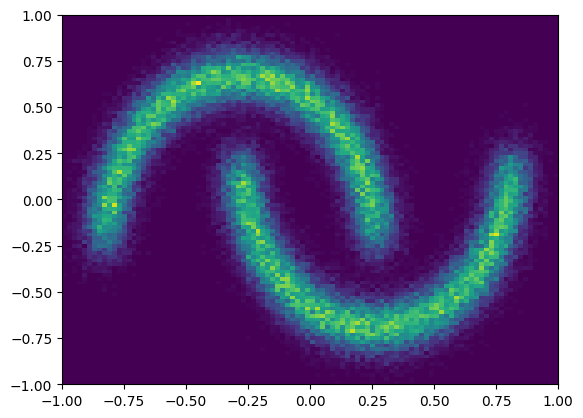

In [213]:
n_samples = 100000

x, _ = datasets.make_moons(n_samples=n_samples, noise=0.1)

scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1),)
x = scaler.fit_transform(x)

plt.hist2d(x[:, 0], x[:, 1], bins=100)
plt.xlim(-1 ,1)
plt.ylim(-1, 1)

In [178]:
class MLP(nn.Module):
    """ A simple MLP in Flax. This is the score function.
    """
    hidden_dim: int = 32
    out_dim: int = 2
    n_layers: int = 2

    @nn.compact
    def __call__(self, x, t):
        
        t = get_timestep_embedding(t[..., 0], dim_t_emb)
        x = np.concatenate([x, t], -1)
        for _ in range(self.n_layers):
            x = nn.Dense(features=self.hidden_dim)(x)
            x = nn.relu(x)
        x = nn.Dense(features=self.out_dim)(x)
        return x
    
def get_timestep_embedding(timesteps, embedding_dim: int, dtype=np.float32):
    """Build sinusoidal embeddings (from Fairseq)."""

    assert len(timesteps.shape) == 1
    timesteps *= 1000

    half_dim = embedding_dim // 2
    emb = np.log(10_000) / (half_dim - 1)
    emb = np.exp(np.arange(half_dim, dtype=dtype) * -emb)
    emb = timesteps.astype(dtype)[:, None] * emb[None, :]
    emb = np.concatenate([np.sin(emb), np.cos(emb)], axis=1)
    if embedding_dim % 2 == 1:  # Zero pad
        emb = jax.lax.pad(emb, dtype(0), ((0, 0, 0), (0, 1, 0)))
    assert emb.shape == (timesteps.shape[0], embedding_dim)
    return emb

In [179]:
def f_theta(params, score, x, t):
    
    sigma_data = 0.5
    
    c_skip = sigma_data ** 2 / ((t - eps) ** 2 + sigma_data ** 2)
    c_out = sigma_data * (t - eps) / np.sqrt(sigma_data ** 2 + t ** 2)
    
    x_out = score.apply(params, x, t)
    
    return x * c_skip + x_out * c_out

In [180]:
@partial(jax.jit, static_argnums=(5,))
def loss_fn(params, params_ema, x, t1, t2, score, key):

    z = jax.random.normal(key, shape=x.shape)

    x2 = x + z * t2
    x2 = f_theta(params, score, x2, t2)
    
    x1 = x + z * t1
    x1 = f_theta(params_ema, score, x1, t1)
    
    return np.mean((x1 - x2) ** 2) 

In [181]:
def karras_boundaries(sigma, eps, N, T):
    """Boundaries for the time discretization."""
    return np.array([(eps ** (1 / sigma) + i / (N - 1) * (T ** (1 / sigma) - eps ** (1 / sigma))) ** sigma for i in range(N)])

In [182]:
key = jax.random.PRNGKey(42)

score = MLP(hidden_dim=128, out_dim=2, n_layers=6)
t = np.ones((x.shape[0], 1))
params = score.init(key, x, t)

In [183]:
from flax.training import train_state
from typing import Any

class TrainState(train_state.TrainState):
    params_ema: Any = None
    
tx = optax.adam(learning_rate=1e-3)

state = TrainState.create(
              apply_fn=score.apply, 
              params=params, 
              tx=tx, 
              params_ema=params)

def apply_ema_decay(state, ema_decay):
    params_ema = jax.tree_map(lambda p_ema, p: p_ema * ema_decay + p * (1. - ema_decay), state.params_ema, state.params)
    state = state.replace(params_ema = params_ema)
    return state

In [191]:
from tqdm import tqdm, trange

num_steps = 70000
num_batch = 128    
    
s0 = 2
s1 = 150
mu0 = 0.9
ema_decay_rate = 0.999

with trange(num_steps) as steps:
    for step in steps:

        N = math.ceil(math.sqrt((step * ((s1 + 1) ** 2 - s0 ** 2) / num_steps) + s0 ** 2) - 1) + 1
        mu = math.exp(s0 * math.log(mu0) / N)
        
        boundaries = karras_boundaries(7.0, eps, N, T)

        # Draw a random batches from x
        key, _ = jax.random.split(key)
        idx = jax.random.choice(key, x.shape[0], shape=(num_batch,))

        x_batch = x[idx]
        key, _ = jax.random.split(key)
        n_batch = jax.random.randint(key, minval=0, maxval=N, shape=(x_batch.shape[0], 1))
        
        key, _ = jax.random.split(key)
        loss, grads = jax.value_and_grad(loss_fn)(state.params, state.params_ema, x_batch, boundaries[n_batch], boundaries[n_batch + 1], score, key)            
        state = state.apply_gradients(grads=grads)
        state = jax.lax.stop_gradient(apply_ema_decay(state, mu))
        
        steps.set_postfix(val=loss)

100%|████████████████████████████████| 70000/70000 [29:26<00:00, 39.64it/s, val=8.755736e-05]


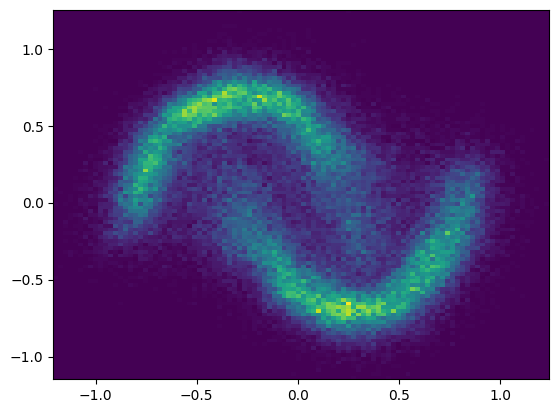

In [220]:
def sample(params, score, ts, key):
    
    x0 = jax.random.normal(key, shape=(n_samples, 2)) * ts[0]
    x = f_theta(params, score, x0, np.repeat(ts[0], x0.shape[0])[:, None])
        
    for t in ts[1:]:
        key, _ = jax.random.split(key)
        z = jax.random.normal(key, shape=x0.shape)
        x = x + math.sqrt(t ** 2 - eps ** 2) * z
        x = f_theta(params, score, x, np.repeat(t, x0.shape[0])[:, None])
        
    return x

n_samples = 100000
x_samples = sample(state.params, score, list(reversed(np.linspace(0.1, T, 5))), key)
x_samples = sample(state.params, score, list(reversed([0.05, 2., T / 4., T / 2., T])), key)
plt.hist2d(x_samples[:, 0], x_samples[:, 1], bins=100);
# plt.xlim(-2 ,2)
# plt.ylim(-2, 2)

In [149]:
import tensorflow as tf
import tensorflow_datasets as tfds

num_batch = 32

# Load MNIST dataset
mnist_dataset, mnist_info = tfds.load(name='mnist', with_info=True, as_supervised=True)

# Split dataset into training and testing sets
mnist_train, mnist_test = mnist_dataset['train'], mnist_dataset['test']

# Define function to normalize pixel values
def normalize(image, label):
    return tf.cast(image, tf.float32) / 255., label

# Apply normalization to both training and testing sets
mnist_train = mnist_train.map(normalize)
mnist_test = mnist_test.map(normalize)

# Shuffle and batch the training set
mnist_train = mnist_train.shuffle(mnist_info.splits['train'].num_examples)
mnist_train = mnist_train.batch(num_batch)

# Batch the testing set
mnist_test = mnist_test.batch(num_batch)

In [76]:
import sys
sys.path.append("../")
from models.unet import Unet

In [77]:
key = jax.random.PRNGKey(42)
params, out = score.init_with_output(key, np.array(list(mnist_train)[0][0]), np.linspace(0., 1., 32))
params.shape

(32, 28, 28, 1)

In [78]:
key = jax.random.PRNGKey(42)

score = Unet(32, dim_mults=(1,2,4), resnet_block_groups=4)
t = np.ones((num_batch))
params = score.init(key, np.array(list(mnist_train)[0][0]), t)